# Opioids in Crisis: So What’s the Government Doing About It?!

In [1]:
# Data wrangling packages
import pandas as pd
import numpy as np

# cleaning
import re

# Visualizing
from matplotlib import pyplot as plt

# so images get plotted in the notebook
%matplotlib inline

# NLP
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords

nltk.download('stopwords') #download the latest stopwords

# Inference
from sklearn import linear_model


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/bryant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Only run this cell if you want to download data straight from the source

from urllib.request import urlopen
from zipfile import ZipFile
from io import BytesIO

z = urlopen('https://federalreporter.nih.gov/FileDownload/DownloadFile?fileToDownload=FedRePORTER_PRJ_C_FY2000.zip')
zipProjects = ZipFile(BytesIO(z.read())).extract('FedRePORTER_PRJ_C_FY2000.csv')
projects = pd.read_csv(zipProjects, skipinitialspace=True, encoding='utf-8')

# loop through rest of years, adding to original df

# setup
fiscal_years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009',
    '2010','2011','2012','2013','2014','2015','2016','2017','2018']
prefix = 'FedRePORTER_PRJ_C_FY'

# concat function
for year in fiscal_years:
    file = prefix + year
    zipUrl = 'https://federalreporter.nih.gov/FileDownload/DownloadFile?fileToDownload=' + file + '.zip'
    csvFile = prefix + year + '.csv'
    
    print('\n')
    print('Downloading ' + zipUrl)
    z = urlopen(zipUrl)
    
    print('Extracting ' + csvFile)
    zipProjects = ZipFile(BytesIO(z.read())).extract(file + '.csv')
    
    print('Appending ' + file)
    projects = projects.append(pd.read_csv(csvFile, skipinitialspace=True, encoding='utf-8'), ignore_index=True)
    
    print('\n')
    print(projects.shape)

# bring in abstract data, starting with 2000
z = urlopen('https://federalreporter.nih.gov/FileDownload/DownloadFile?fileToDownload=FedRePORTER_PRJABS_C_FY2000.zip')
zipAbstracts = ZipFile(BytesIO(z.read())).extract('FedRePORTER_PRJABS_C_FY2000.csv')
abstracts = pd.read_csv(zipAbstracts, skipinitialspace=True, encoding='utf-8')

# loop through rest of years, adding to original df

# setup
fiscal_years = ['2001','2002','2003','2004','2005','2006','2007','2008','2009',
    '2010','2011','2012','2013','2014','2015','2016','2017','2018']
prefix = 'FedRePORTER_PRJABS_C_FY'

# concat function
for year in fiscal_years:
    file = prefix + year
    zipUrl = 'https://federalreporter.nih.gov/FileDownload/DownloadFile?fileToDownload=' + file + '.zip'
    csvFile = prefix + year + '.csv'
    
    print('\n')
    print('Downloading ' + zipUrl)
    z = urlopen(zipUrl)
    
    print('Extracting ' + csvFile)
    zipAbstracts = ZipFile(BytesIO(z.read())).extract(file + '.csv')
    
    print('Appending ' + file)
    abstracts = abstracts.append(pd.read_csv(csvFile, skipinitialspace=True, encoding='utf-8'), ignore_index=True)
    print('\n')
    print(abstracts.shape)

# merge projects and abstracts by PROJECT_ID
merged = pd.merge(projects, abstracts, on='PROJECT_ID')

print(merged.shape)

# export to csv to obviate need for downloading again in future
merged.to_csv('mergedProjectsAbstracts.csv',encoding='utf-8-sig')


In [2]:
# run this cell to import merged csv instead of above cell

df = pd.read_csv('mergedProjectsAbstracts.csv',encoding='utf-8-sig')

/Users/bryant/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (13,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Limit our data to NIH only
dfNIH = df[df.AGENCY == 'NIH']

In [4]:
# Create a variable indicating whether each project has opioid in the project terms

dfNIH['projectTermsFlag'] = pd.to_numeric(np.where(
    dfNIH['PROJECT_TERMS'].str.contains("opioid", case=False, na=False), 1, ''))


/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


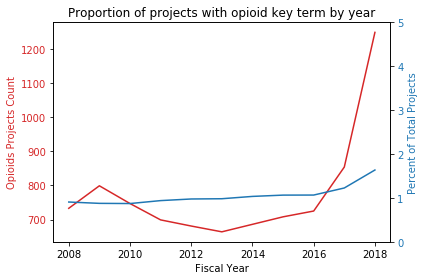

In [5]:
# Create a plot counting opioid-related projects over time

opioidProjectCounts = dfNIH.projectTermsFlag.groupby(dfNIH.FY).agg('count')
opioidProjectCounts = opioidProjectCounts[opioidProjectCounts.index>2007]

totalProjs = dfNIH.FY.value_counts().sort_index()
totalProjs = totalProjs[totalProjs.index>2007]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Opioids Projects Count', color=color)
ax1.plot(opioidProjectCounts.index,opioidProjectCounts.values, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Percent of Total Projects', color=color)
ax2.plot(totalProjs.index,(opioidProjectCounts.values/totalProjs.values)*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.0,5.0])

plt.title('Proportion of projects with opioid key term by year')
fig.tight_layout()
plt.show();
fig.savefig('projectCountsOverTime.png')

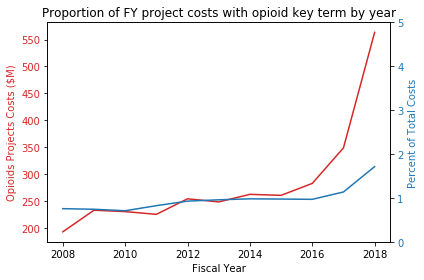

In [6]:
# Create a plot relating opioid project cost totals (in $ millions)

opioidProjectCosts = dfNIH.groupby(['FY','projectTermsFlag'])[['FY_TOTAL_COST']].sum().values/1000000
totalProjectCosts = dfNIH.groupby(['FY'])[['FY_TOTAL_COST']].sum().values/1000000
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Fiscal Year')
ax1.set_ylabel('Opioids Projects Costs ($M)', color=color)
ax1.plot(years,opioidProjectCosts, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Percent of Total Costs', color=color)
ax2.plot(years,(opioidProjectCosts/totalProjectCosts)*100, color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim([0.0,5.0])

plt.title('Proportion of FY project costs with opioid key term by year')
fig.tight_layout()
plt.show();
fig.savefig('projectCostsOverTime.png')

# Text analysis (Topic modeling)

LDA (Latent Dirichlet Allocation) is a model used for discovering abstract topics from a collection of documents. These 'latent' topics can be discovered based on observed data -- words in the documents, in this case.

To surface these topics, we create a matrix where each document is a row and each column is a word in the corpus vocabulary. The corpus vocabulary is the universe of words present in any one or more documents in the corpus (minus chosen 'stopwords' that we consider to provide little information).

Each cell of the matrix would be a count of that word in that document. A variant increases the level of sophistication by using a normalized version of these counts known as TF-IDF. TF stands for term-frequency and TF-IDF is term-frequency times inverse document-frequency. In other words, we are not only looking for how often a word appears in a given document, but also whether this particular word is distinct across all the collections of documents (corpus). For example, intuitively we understand that words like "often" or "use" are more frequently encountered, but they are less informative (more semantically-vacuous) if we want to discern a particular topic of a document, as they might be frequently encounter across all text documents in a corpus. On the other hand, words which we will see less frequently across a collection of document might indicate that those words are specific to a particular document, and, therefore, constitute a basis for a topic.

We provide the model with this matrix and how many topics we want it to use. Think of it like a k-means clustering analog. The model will then iterate a specified number of times considering two distributions; 1) which words in the vocabulary are more or less probable to belong in a given topic and 2) which topic is more or less probable for a given document.

The main assumptions, if this all went over your head:
* each document consists of a mixture of topics, and
* each topic consists of a collection of words.


In [7]:
# Subset to only those projects flagged as opioid related

opioidSubset = dfNIH[dfNIH.projectTermsFlag == 1]
print(opioidSubset.shape)
print('Not nulls: ' + str(opioidSubset.ABSTRACT.notnull().sum()))
print('Nulls: ' + str(opioidSubset.ABSTRACT.isnull().sum()))
opioidSubset[['ABSTRACT','PROJECT_TITLE']][opioidSubset.ABSTRACT.isnull()]

(8545, 27)
Not nulls: 8530
Nulls: 15


,ABSTRACT,PROJECT_TITLE
25235,NaN,MEDICAL STUDENT TRAINING ON BUPRENORPHINE AND ...
51375,NaN,ORAL OPIOID TREATMENT AND PSYCHIATRIC COMORBIDITY
58859,NaN,DELAWARE VALLEY NODE OF THE CLINICAL TRIALS NE...
151188,NaN,ORAL OPIOID TREATMENT AND PSYCHIATRIC COMORBIDITY
258860,NaN,ORAL OPIOID TREATMENT AND PSYCHIATRIC COMORBIDITY
361940,NaN,ORAL OPIOID TREATMENT AND PSYCHIATRIC COMORBIDITY
421100,NaN,SMALL MOLECULE IDENTIFICATION FOR THE NOCICEPT...
425444,NaN,PROJECT 3 - DEVELOPMENTAL EXPOSURE ALCOHOL RES...
425447,NaN,PILOT 4 - DEVELOPMENTAL EXPOSURE ALCOHOL RESEA...
442259,NaN,IN VIVO CHEMICAL MONITORING USING CAPILLARY SE...


In [8]:
# Those 15 nulls will mess up our analysis.
# But rather than drop them entirely, lets use their project title, which is not missing
# as their abstract data instead

opioidSubsetNoNulls = opioidSubset
print('Before addressing nulls, null count is: '  + str(opioidSubset.ABSTRACT.isnull().sum()))
opioidSubsetNoNulls['ABSTRACT'] = np.where(
    opioidSubsetNoNulls.ABSTRACT.isnull(),
    opioidSubsetNoNulls.PROJECT_TITLE,
    opioidSubsetNoNulls.ABSTRACT)
print('AFTER addressing nulls, null count is: '  + str(opioidSubsetNoNulls.ABSTRACT.isnull().sum()))


Before addressing nulls, null count is: 15
AFTER addressing nulls, null count is: 0


/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [9]:
# Project abstracts are also duplicated when they are active over multiple fiscal years
# we will drop these to prevent the topic modeling from going astray

print('Before deduping, shape is: ' + str(opioidSubsetNoNulls.shape))
opioidSubsetNoNullsDedup = opioidSubsetNoNulls.drop_duplicates(subset=['ABSTRACT'])
print('After deduping, shape is: ' + str(opioidSubsetNoNullsDedup.shape))


Before deduping, shape is: (8545, 27)
After deduping, shape is: (4142, 27)


In [10]:
# lets clean the messy data before running analysis on it

# a regex pattern to help eliminate punctuation
nonchars = re.compile( r'\W+|\d+' )

# function to elim punctuation and set to lower case
def clean(text):
    return re.sub(nonchars, " ", text).lower()

opioidSubsetNoNullsDedup['cleanText'] = opioidSubsetNoNullsDedup.ABSTRACT.apply(clean)


/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [11]:
# Get only the text of the cleaned abstracts

corpus = opioidSubsetNoNullsDedup['cleanText'].values.tolist()

In [12]:
# stop words and stemming them
stemmer = nltk.SnowballStemmer('english')
eng_stopwords = stopwords.words('english')
add_stopwords = ['understand','method']
comb_stopwords = eng_stopwords + add_stopwords
stemmed_stopwords = []

for w in comb_stopwords:
    stemmed_stopwords.append(stemmer.stem(w))
    

In [13]:
'''
Before we can apply LDA, we need to create a vocabulary with all the words in our data
We specify to only include those words that appear in less than 10% of the document 
and appear in at least 0.5% of documents. 
docs: https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
''';

# prepare our vectorizer
analyzer = CountVectorizer().build_analyzer()

# our stemming function
def stemmed_words(doc):
    return (stemmer.stem(w) for w in analyzer(doc))

stem_vectorizer = CountVectorizer(analyzer=stemmed_words,
                                  max_df=0.10,
                                  min_df=0.005,
                                  ngram_range = (0,2),
                                  stop_words=stemmed_stopwords)

noStem_vectorizer = CountVectorizer(max_df=0.10,
                                  min_df=0.005,
                                    ngram_range = (0,2),
                                   stop_words=eng_stopwords)


# uncomment the two lines below, then comment the subsequent lines to use stemming
# stemming probably provides better topics, given similar words are grouped, but
# it yields word/n-gram fragments that are harder to read...

# doc_term_matrix = stem_vectorizer.fit_transform(corpus)
# doc_term_features = stem_vectorizer.get_feature_names()

# I used the below for the blog, as the n-grams are easier to read

doc_term_matrix = noStem_vectorizer.fit_transform(corpus)
doc_term_features = noStem_vectorizer.get_feature_names()


In [14]:
'''
Using below code, we can print out the many, many words excluded due to:
- occurred in too many documents (max_df)
- occurred in too few documents (min_df)
- were cut off by feature selection (max_features)
''';

# print(count_vect.stop_words_)

In [15]:
# Use LDA to create topics.

LDA = LatentDirichletAllocation(n_components=10, random_state=1)  
LDA.fit(doc_term_matrix)


LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=1, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [16]:
# initialize list for topics
topicList = []

# fill out topics list as top 15 words in each topic
for i,topic in enumerate(LDA.components_):
    ithTopic = [doc_term_features[i] for i in topic.argsort()[-15:]]
    topicList.append(ithTopic)
    
# print(*topicList, sep="\n\n")

'''
By construction, all words in the entire corpus are in all topics, but by looking
at the top most-important words in each topic, we get an idea how they differ.
Ultimately, the algorithm only groups the words/n-grams, it is up to humans to 
decide what those words mean. Looking at our topics, we might say that relate to...

''';

topicNames = ['Health study terms',
              'Conditions opioids are prescribed for',
              'HIV and infections',
              'Dependence and recovery',
              'Molecular underpinnings',
              'Nervous sytem related',
              'Patient population types',
              'Depression, anxiety',
              'Cellular mechanisms',
              'Tobacco and other substances'
             ]

topicListDf = pd.DataFrame({'name':topicNames, 'keyword':topicList})
topicListDf

,name,keyword
0,Health study terms,"[community, plan, skills, independent, candida..."
1,Conditions opioids are prescribed for,"[policy, painful, cell disease, oa, inflammati..."
2,HIV and infections,"[hiv infected, microglia, social, inflammatory..."
3,Dependence and recovery,"[mg, outcome, craving, weeks, cancer, oral, ma..."
4,Molecular underpinnings,"[compound, potent, anti, cancer, kappa, assays..."
5,Nervous sytem related,"[nerve, coupled, phosphorylation, inhibition, ..."
6,Patient population types,"[veterans, prescribing, pregnant, surgery, pai..."
7,"Depression, anxiety","[fmri, females, adolescent, social, structure,..."
8,Cellular mechanisms,"[accumbens, glutamate, gaba, neural, consumpti..."
9,Tobacco and other substances,"[smokers, social, substance use, drug users, t..."


In [17]:
'''
Assign the probability of all the topics to each document, then
add a column to the original data frame that will store the highest-scoring
topic for that abstract.
''';

# matrix where each row is an abstract, each column a topic. Each cell is value of that topic for that abstract.
topic_values = LDA.transform(doc_term_matrix)  

'''
take the column number associated with the highest value in a given row, store in our analytical dataframe
''';
opioidSubsetNoNullsDedup['primeTopicId'] = topic_values.argmax(axis=1)

'''
store the valence of that prime topic for that abstract as well
''';
opioidSubsetNoNullsDedup['primeTopicValence'] = topic_values.max(axis=1)

print("Shape of topic_values: ",(topic_values.shape))

Shape of topic_values:  (4142, 10)


/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]
/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


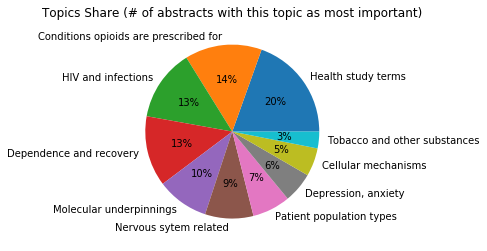

In [18]:
# what's the distribution like by topic?

# plot the distribution
topicDistDf = pd.DataFrame({'share':opioidSubsetNoNullsDedup['primeTopicId'].value_counts().values,
                            'topics':topicNames})

ax = topicDistDf.plot(y='share',kind='pie',
                      labels=topicDistDf['topics'],
                      autopct = '%1.0f%%', legend=False, 
                      title='Topics Share (# of abstracts with this topic as most important)')
# Hide y-axis label
ax.set(ylabel='');

fig = ax.get_figure()
fig.savefig('topicsPie.png',bbox_inches='tight')

In [19]:
pd.crosstab(opioidSubsetNoNullsDedup.primeTopicId,
            opioidSubsetNoNullsDedup.FY,margins=True)

FY,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,All
primeTopicId,,,,,,,,,,,,
0,92,21,26,25,73,43,42,40,16,55,119,552
1,9,6,10,11,23,14,7,9,11,7,22,129
2,50,29,12,18,35,32,15,19,16,25,42,293
3,60,34,19,16,52,51,22,23,22,22,51,372
4,71,34,25,25,56,32,29,28,24,31,46,401
5,190,67,43,37,92,73,59,58,38,45,107,809
6,85,35,15,23,60,52,44,33,47,73,126,593
7,35,18,11,17,38,31,12,12,13,17,30,234
8,102,50,25,27,76,48,42,43,31,37,61,542


In [20]:
pd.crosstab(opioidSubsetNoNullsDedup.primeTopicId,
            opioidSubsetNoNullsDedup.FY,margins=True).values[10][:11]

array([710, 304, 203, 212, 531, 394, 285, 274, 238, 348, 643])

In [21]:
lines = pd.crosstab(opioidSubsetNoNullsDedup.primeTopicId,
            opioidSubsetNoNullsDedup.FY,margins=True).values

lines[9][:11]/lines[10][:11]

array([0.02253521, 0.03289474, 0.08374384, 0.06132075, 0.04896422,
       0.04568528, 0.04561404, 0.03284672, 0.08403361, 0.10344828,
       0.06065319])

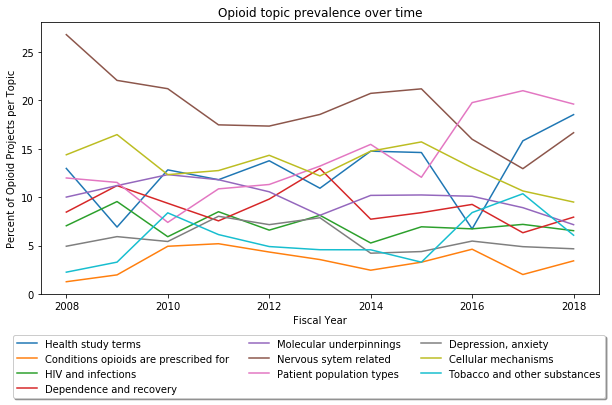

In [22]:
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018]
lines = pd.crosstab(opioidSubsetNoNullsDedup.primeTopicId,
            opioidSubsetNoNullsDedup.FY,margins=True).values

fig = plt.figure(figsize=(10, 5))

line1, = plt.plot(years,(lines[0][:11]/lines[10][:11])*100,label=topicNames[0])
line2, = plt.plot(years,(lines[1][:11]/lines[10][:11])*100,label=topicNames[1])
line3, = plt.plot(years,(lines[2][:11]/lines[10][:11])*100,label=topicNames[2])
line4, = plt.plot(years,(lines[3][:11]/lines[10][:11])*100,label=topicNames[3])
line5, = plt.plot(years,(lines[4][:11]/lines[10][:11])*100,label=topicNames[4])
line6, = plt.plot(years,(lines[5][:11]/lines[10][:11])*100,label=topicNames[5])
line7, = plt.plot(years,(lines[6][:11]/lines[10][:11])*100,label=topicNames[6])
line8, = plt.plot(years,(lines[7][:11]/lines[10][:11])*100,label=topicNames[7])
line9, = plt.plot(years,(lines[8][:11]/lines[10][:11])*100,label=topicNames[8])
line10, = plt.plot(years,(lines[9][:11]/lines[10][:11])*100,label=topicNames[9])

plt.xlabel('Fiscal Year')
plt.ylabel('Percent of Opioid Projects per Topic')
plt.legend(loc='lower center', bbox_to_anchor=(0.48, -0.4),
          ncol=3, fancybox=True, shadow=True)
plt.title('Opioid topic prevalence over time');

fig.savefig('topicsOverTime.png',bbox_inches='tight')    
    

In [23]:
opioidSubsetNoNullsDedup.columns

Index(['Unnamed: 0', 'PROJECT_ID', 'PROJECT_TERMS', 'PROJECT_TITLE',
       'DEPARTMENT', 'AGENCY', 'IC_CENTER', 'PROJECT_NUMBER',
       'PROJECT_START_DATE', 'PROJECT_END_DATE', 'CONTACT_PI_PROJECT_LEADER',
       'OTHER_PIS', 'CONGRESSIONAL_DISTRICT', 'DUNS_NUMBER',
       'ORGANIZATION_NAME', 'ORGANIZATION_CITY', 'ORGANIZATION_STATE',
       'ORGANIZATION_ZIP', 'ORGANIZATION_COUNTRY', 'BUDGET_START_DATE',
       'BUDGET_END_DATE', 'CFDA_CODE', 'FY', 'FY_TOTAL_COST',
       'FY_TOTAL_COST_SUB_PROJECTS', 'ABSTRACT', 'projectTermsFlag',
       'cleanText', 'primeTopicId', 'primeTopicValence'],
      dtype='object')

In [24]:
# be aware of missings
print(opioidSubsetNoNullsDedup.isnull().sum())

Unnamed: 0                       0
PROJECT_ID                       0
PROJECT_TERMS                    0
PROJECT_TITLE                    0
DEPARTMENT                       0
AGENCY                           0
IC_CENTER                        0
PROJECT_NUMBER                   0
PROJECT_START_DATE             485
PROJECT_END_DATE               478
CONTACT_PI_PROJECT_LEADER        0
OTHER_PIS                     3624
CONGRESSIONAL_DISTRICT         352
DUNS_NUMBER                      2
ORGANIZATION_NAME                1
ORGANIZATION_CITY                0
ORGANIZATION_STATE              22
ORGANIZATION_ZIP               306
ORGANIZATION_COUNTRY             0
BUDGET_START_DATE              331
BUDGET_END_DATE                331
CFDA_CODE                      581
FY                               0
FY_TOTAL_COST                  322
FY_TOTAL_COST_SUB_PROJECTS    3838
ABSTRACT                         0
projectTermsFlag                 0
cleanText                        0
primeTopicId        

In [25]:
opioidSubsetNoNullsDedup.FY_TOTAL_COST.describe()

count    3.820000e+03
mean     4.221204e+05
std      5.273420e+05
min      1.000000e+00
25%      1.823040e+05
50%      3.111280e+05
75%      4.960730e+05
max      9.492078e+06
Name: FY_TOTAL_COST, dtype: float64

In [26]:
from statsmodels.formula.api import ols

# drop rows with no lefthand var
regData = opioidSubsetNoNullsDedup.dropna(subset=['FY_TOTAL_COST'])
regData['cost_millions'] = regData.FY_TOTAL_COST/1000000
fit = ols('cost_millions ~ C(primeTopicId) + C(ORGANIZATION_STATE) + C(FY)', data=regData).fit() 

fit.summary()

/Users/bryant/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          cost_millions   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     6.567
Date:                Tue, 13 Aug 2019   Prob (F-statistic):           9.06e-52
Time:                        15:22:22   Log-Likelihood:                -2758.3
No. Observations:                3798   AIC:                             5651.
Df Residuals:                    3731   BIC:                             6069.
Df Model:                          66                                         
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.2676      0.162      1.650      0.099      -0.050       0.585
C(primeTopicId)[T.1]           -0.1120      0.054     -2.066      0.039      -0.218      -0.006
C(primeTopicId)[T.2]           -0.0126      0.040     -0.316      0.752      -0.091       0.066
C(primeTopicId)[T.3]            0.1034      0.036      2.856      0.004       0.032       0.174
C(primeTopicId)[T.4]           -0.0677      0.036     -1.877      0.061      -0.138       0.003
C(primeTopicId)[T.5]           -0.1403      0.030     -4.654      0.000      -0.199      -0.081
C(primeTopicId)[T.6]           -0.1167      0.032     -3.616      0.000      -0.180      -0.053
C(primeTopicId)[T.7]           -0.1001      0.042     -2.389      0.017      -0.182      -0.018
C(primeTopicId)[T.8]           -0.0704      0.033     -2.134      0.033      -0.135      -0.006
C(primeTopicId)[T.9]            0.0275      0.043      0.634      0.526      -0.057       0.112
C(ORGANIZATION_STATE)[T.AR]    -0.0025      0.204     -0.012      0.990      -0.402       0.397
C(ORGANIZATION_STATE)[T.AZ]     0.0814      0.180      0.453      0.650      -0.271       0.433
C(ORGANIZATION_STATE)[T.BC]    -0.0354      0.242     -0.146      0.884      -0.509       0.439
C(ORGANIZATION_STATE)[T.CA]     0.1104      0.162      0.683      0.495      -0.207       0.428
C(ORGANIZATION_STATE)[T.CO]    -0.0056      0.175     -0.032      0.975      -0.349       0.338
C(ORGANIZATION_STATE)[T.CT]     0.0718      0.166      0.432      0.666      -0.254       0.398
C(ORGANIZATION_STATE)[T.DC]    -0.0698      0.196     -0.355      0.723      -0.455       0.315
C(ORGANIZATION_STATE)[T.DE]     0.1158      0.333      0.347      0.728      -0.537       0.769
C(ORGANIZATION_STATE)[T.FL]     0.0627      0.169      0.372      0.710      -0.268       0.393
C(ORGANIZATION_STATE)[T.GA]    -0.0168      0.189     -0.089      0.929      -0.388       0.354
C(ORGANIZATION_STATE)[T.IA]     0.0383      0.200      0.192      0.848      -0.353       0.430
C(ORGANIZATION_STATE)[T.IL]     0.0743      0.172      0.433      0.665      -0.262       0.411
C(ORGANIZATION_STATE)[T.IN]     0.0450      0.179      0.251      0.802      -0.306       0.396
C(ORGANIZATION_STATE)[T.KS]     0.0742      0.192      0.387      0.699      -0.302       0.450
C(ORGANIZATION_STATE)[T.KY]     0.2735      0.171      1.599      0.110      -0.062       0.609
C(ORGANIZATION_STATE)[T.LA]    -0.1239      0.240     -0.516      0.606      -0.595       0.347
C(ORGANIZATION_STATE)[T.MA]     0.0767      0.163      0.470      0.638      -0.243       0.397
C(ORGANIZATION_STATE)[T.MD]     0.4009      0.162      2.477      0.013       0.084       0.718
C(ORGANIZATION_STATE)[T.ME]     0.1166      0.232      0.502      0.616      -0.339       0.572
C(ORGANIZAT

In [27]:
opioidSubsetNoNullsDedup.ORGANIZATION_STATE.value_counts().sort_values(ascending=False)

CA    535
MD    520
NY    422
MA    289
PA    271
NC    172
CT    140
MN    134
TX    131
WA    128
MI    120
FL    101
VA    100
OR     75
KY     74
IL     72
MO     72
RI     71
SC     59
OH     55
WI     52
CO     51
AZ     49
NJ     44
TN     42
IN     41
GA     31
UT     24
KS     23
VT     23
DC     21
IA     19
MS     18
AR     16
NH     14
NM     14
PR     12
AL     12
ME     10
NE     10
ON      9
LA      8
BC      8
OK      7
MT      6
QC      6
WV      5
DE      4
Name: ORGANIZATION_STATE, dtype: int64